In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import pandas as pd
import numpy as np
import random
import os
from shutil import copyfile
import shutil
import matplotlib.pyplot as plt
import cv2

In [ ]:
print(len(os.listdir('/gdrive/MyDrive/AML_FashionDataset/topwear')))
print(len(os.listdir('/gdrive/MyDrive/AML_FashionDataset/bottomwear')))
print(len(os.listdir('/gdrive/MyDrive/AML_FashionDataset/footwear')))

100
102
100


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from PIL import Image
from skimage.transform import resize

#### Resizing images and converting to grayscale (Part 3 preprocessing)

In [ ]:
def load_and_preprocess_images(*folder_path):

    image_files = []
    images = []
    labels = []

    for fp in folder_path:

      image_files = sorted(os.listdir(fp))

      for filename in image_files:

        img = Image.open(os.path.join(fp, filename))
        img = img.convert('L')
        img = img.resize((224,224))
        img_array = np.array(img)
        images.append(img_array)

        if 'topwear' in filename:
          label = 1
        if 'bottomwear' in filename:
          label = 2
        if 'footwear' in filename:
          label = 3

        labels.append(label)


    return images, labels

In [ ]:
import os
import numpy as np
import tensorflow as tf
from keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from scipy.spatial import procrustes
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import time

np.random.seed(42)
tf.random.set_seed(42)

images, labels = load_and_preprocess_images('/gdrive/MyDrive/AML_FashionDataset/topwear/',
                                            '/gdrive/MyDrive/AML_FashionDataset/bottomwear/',
                                            '/gdrive/MyDrive/AML_FashionDataset/footwear/')

all_images = np.array(images)
all_labels = np.array(labels)
all_labels = np.array(pd.get_dummies(all_labels))

# Part 2: Split the images into a training set, a validation set, and a test set.

In [ ]:
from sklearn.utils import shuffle

X, y = shuffle(all_images, all_labels, random_state=42)  # shuffle to ensure that the images of each class occur one after the other in a random order rather than class 0 being followed by class 1 and then class 2
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42) # stratify to ensure that equal proportions of each class are present in each set
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5, stratify=y_test_val, random_state=42)

In [ ]:
print(len(X_train))
print(len(X_val))
print(len(X_test))

241
31
30


In [ ]:
from collections import Counter

train_lab_list = []
for i in y_train:
  train_lab_list.append(list(i).index(1))
print(Counter(train_lab_list))

val_lab_list = []
for i in y_val:
  val_lab_list.append(list(i).index(1))
print(Counter(val_lab_list))

test_lab_list = []
for i in y_test:
  test_lab_list.append(list(i).index(1))
print(Counter(test_lab_list))

Counter({0: 81, 1: 80, 2: 80})
Counter({1: 11, 2: 10, 0: 10})
Counter({0: 10, 2: 10, 1: 10})


# Part 3: Build the input pipeline, including the appropriate preprocessing operations, and add data augmentation.

In [ ]:
image_size = 224

X_train = X_train.reshape(-1, image_size, image_size, 1)
X_val = X_val.reshape(-1, image_size, image_size, 1)
X_test = X_test.reshape(-1, image_size, image_size, 1)

# y_train = np.array(pd.get_dummies(y_train))
# y_val = np.array(pd.get_dummies(y_val))
# y_test = np.array(pd.get_dummies(y_test))

datagen_train = ImageDataGenerator(
    rotation_range=180,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True  # Allowing vertical flip as well
)

# Part 4: Fine-tune a pretrained model of your choice on this dataset (the one you created in part 3). Report classification accuracy and give a few examples of correct/incorrect classification (show a few images that were correctly/incorrectly classified).

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
import numpy as np
from tensorflow.keras.applications.vgg16 import preprocess_input

image_paths = []
image_labels = []

categories = ['topwear','bottomwear','footwear']
for category in categories:

    category_dir = os.path.join('/gdrive/MyDrive/AML_FashionDataset/', category)

    # Get a list of all image files in the category
    category_images = [os.path.join(category_dir, img) for img in os.listdir(category_dir) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Add image paths to the list
    image_paths.extend(category_images)

    # Add labels (category) to the list
    image_labels.extend([category] * len(category_images))

# Use train_test_split to split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(image_paths, image_labels, test_size=0.2, random_state=42)

# Further split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2 (20% for validation)

# Display the number of samples in each set
print("Number of training samples:", len(X_train))
print("Number of validation samples:", len(X_val))
print("Number of testing samples:", len(X_test))

# Assuming you have a DataFrame df with 'image_path' and 'label' columns
df_train = pd.DataFrame({'image_path': X_train, 'label': y_train})
df_val = pd.DataFrame({'image_path': X_val, 'label': y_val})
df_test = pd.DataFrame({'image_path': X_test, 'label': y_test})

# Define image size and batch size
img_size = (224, 224)
batch_size = 32

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

validation_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)

# Create data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='image_path',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col='image_path',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)

# Create the test generator
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='image_path',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Set to False to maintain the order
)

# Load pre-trained models

#Trying with ResNet50 & then InceptionV3
base_models = [ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
 tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))]

# Freeze the base model layers
for base_model in base_models:
  print(f"Training with {base_model} pretrained layers")
  for layer in base_model.layers:
      layer.trainable = False

  # Create your custom classification head
  num_classes = len(set(y_train))

  model = models.Sequential([
      base_model,
      layers.GlobalAveragePooling2D(),
      layers.Dense(128, activation='relu'),
      layers.Dropout(0.5),
      layers.Dense(num_classes, activation='softmax')
  ])

  # Compile the model
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  # Train the model
  epochs = 10  # Adjust the number of epochs as needed
  model.fit(
      train_generator,
      epochs=epochs,
      validation_data=validation_generator
  )

  # Evaluate the model
  test_loss, test_acc = model.evaluate(test_generator)
  print(f'Test accuracy: {test_acc}')

  if test_acc < 1:
    # Make predictions on the test set
    predictions = model.predict(test_generator)

    # Get the predicted labels
    predicted_labels = np.argmax(predictions, axis=1)

    # Get the true labels
    true_labels = test_generator.classes

    # Find indices of incorrect and correct predictions
    incorrect_indices = np.where(predicted_labels != true_labels)[0]
    correct_indices = np.where(predicted_labels == true_labels)[0]

    # Extract corresponding image paths for reporting
    incorrect_image_paths = df_test.iloc[incorrect_indices]['image_path'].tolist()
    correct_image_paths = df_test.iloc[correct_indices]['image_path'].tolist()

    # Report incorrect and correct classified examples
    print("Incorrectly Classified Examples:")
    for image_path in incorrect_image_paths:
        print(image_path)

    print("\nCorrectly Classified Examples:")
    for image_path in correct_image_paths:
        print(image_path)



Number of training samples: 180
Number of validation samples: 61
Number of testing samples: 61
Found 180 validated image filenames belonging to 3 classes.
Found 61 validated image filenames belonging to 3 classes.
Found 61 validated image filenames belonging to 3 classes.
87910968/87910968 [==============================] - 0s 0us/step
Training with <keras.src.engine.functional.Functional object at 0x7c755c55af80> pretrained layers
Epoch 1/10
6/6 [==============================] - 50s 6s/step - loss: 1.5968 - accuracy: 0.3278 - val_loss: 1.3368 - val_accuracy: 0.2623
Epoch 2/10
6/6 [==============================] - 35s 6s/step - loss: 1.1880 - accuracy: 0.3778 - val_loss: 1.0272 - val_accuracy: 0.4262
Epoch 3/10
6/6 [==============================] - 35s 6s/step - loss: 1.1552 - accuracy: 0.4000 - val_loss: 1.0080 - val_accuracy: 0.5902
Epoch 4/10
6/6 [==============================] - 35s 6s/step - loss: 1.0338 - accuracy: 0.4333 - val_loss: 0.9944 - val_accuracy: 0.4918
Epoch 5/10
6

##Fine Tuning:
###First Pre-trained Layer Model - ResNet50
1. Training accuracy reaches 67.22% after 10 epochs.
2. Test accuracy is 68.85%, which doesn't seems like great accuracy given we are using pre-trained model.
3. We oberved val accuracy of 52.46% which implies the ResNet with frozen layers is underfitting, so we tried making the model a little more complex with increasing the number of neurons in additional dense layers from 128 to 256 and 512, but the accuracy still didn't go up significantly.
4. We tried early stopping and reducing LR on plateau techniques along with Adam optimizer and dropout layer for fine tuning and optimization but still the accuracy went upto max 82% with a random split of train, validation and test set case.
5. Then, based on results we tried to use different set of pretrained layer model i.e. Google's InceptionV3

###Second Pre-trained Layer Model - InceptionV3
1. The model achieves strong performance on both the training and validation sets.
2. The test accuracy is also high at 95.08%, suggesting good generalization to unseen data.
3. The training process seems stable with consistent improvement in both loss and accuracy over epochs.
4. For both the models we used preprocess_input from vgg16 pretrained model, the preprocess input from vgg16 combined with InceptionV3 model gave good results (95% accuracy), with frozen layers and GlobalAveragePoolingLayer, Dense layer on top with 128 neurons and 0.5 dropout along with Adam optimizer while compiltation.

## Incorrectly Classified Images

(-0.5, 3023.5, 4031.5, -0.5)

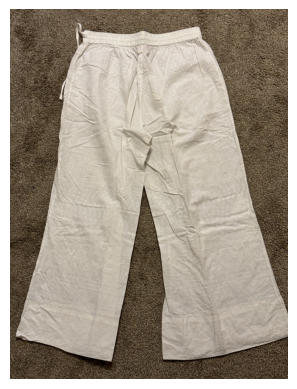

In [23]:
img = Image.open(os.path.join('/gdrive/MyDrive/AML_FashionDataset/bottomwear', 'bottomwear_93.jpg'))
img_array = np.array(img)  # Convert image to numpy array
plt.imshow(img_array)
plt.axis('off')

(-0.5, 3999.5, 2999.5, -0.5)

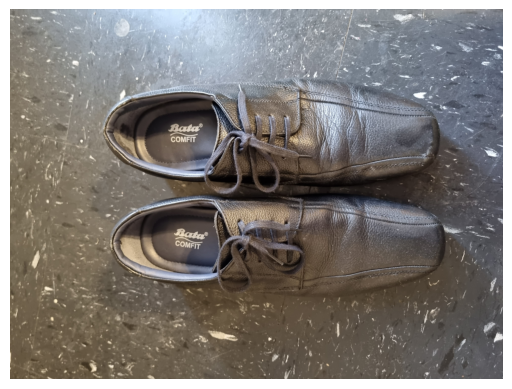

In [24]:
img = Image.open(os.path.join('/gdrive/MyDrive/AML_FashionDataset/footwear', 'footwear_45.jpg'))
img_array = np.array(img)  # Convert image to numpy array
plt.imshow(img_array)
plt.axis('off')

(-0.5, 3023.5, 4031.5, -0.5)

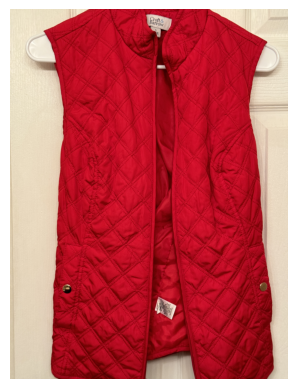

In [25]:
img = Image.open(os.path.join('/gdrive/MyDrive/AML_FashionDataset/topwear', 'topwear_6.jpg'))
img_array = np.array(img)  # Convert image to numpy array
plt.imshow(img_array)
plt.axis('off')

# Part 5: Train from scratch (without pretraining) a deep neural network that contains convolutional layers on this dataset (the one you created in part 3). Report classification accuracy and give a few examples of correct/incorrect classification (show a few images that were correctly/incorrectly classified).

In [ ]:
from tensorflow.keras.optimizers import Adam, Nadam

# model.add(BatchNormalization())
# # model.add(Dropout(0.25))

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.1))
model.add(Dense(3, activation='softmax'))

start_time = time.time()

# Compile the model with a smaller learning rate
model.compile(optimizer='adagrad', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
history = callbacks.History()

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Learning rate scheduler
def lr_schedule(epoch):
    lr = 0.0001
    if epoch >30:
        lr *= 0.1
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

# Training with data augmentation
model.fit(datagen_train.flow(X_train, y_train, batch_size=16),
          epochs=50,
          validation_data=(X_val, y_val),
          verbose=1,
          steps_per_epoch=X_train.shape[0] // 16,
          callbacks=[history, early_stopping, lr_scheduler])

end_time = time.time()

training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

Epoch 1/50
15/15 [==============================] - 4s 118ms/step - loss: 3.5625 - accuracy: 0.3733 - val_loss: 0.8530 - val_accuracy: 0.5806 - lr: 1.0000e-04
Epoch 2/50
15/15 [==============================] - 1s 75ms/step - loss: 1.5701 - accuracy: 0.3867 - val_loss: 0.8983 - val_accuracy: 0.6774 - lr: 1.0000e-04
Epoch 3/50
15/15 [==============================] - 1s 73ms/step - loss: 1.3423 - accuracy: 0.4489 - val_loss: 0.7911 - val_accuracy: 0.6774 - lr: 1.0000e-04
Epoch 4/50
15/15 [==============================] - 1s 69ms/step - loss: 1.1689 - accuracy: 0.4800 - val_loss: 0.9018 - val_accuracy: 0.5806 - lr: 1.0000e-04
Epoch 5/50
15/15 [==============================] - 1s 76ms/step - loss: 1.1554 - accuracy: 0.4978 - val_loss: 0.7662 - val_accuracy: 0.6774 - lr: 1.0000e-04
Epoch 6/50
15/15 [==============================] - 1s 71ms/step - loss: 1.0004 - accuracy: 0.5867 - val_loss: 0.8541 - val_accuracy: 0.5806 - lr: 1.0000e-04
Epoch 7/50
15/15 [==============================] -

In [ ]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc}')

1/1 [==============================] - 0s 51ms/step - loss: 0.5342 - accuracy: 0.9000
Test accuracy: 0.8999999761581421


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(predictions, axis=1)

print("Classification Report:\n", classification_report(y_test_classes, y_pred_classes))

1/1 [==============================] - 0s 20ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.82      0.90      0.86        10
           2       1.00      1.00      1.00        10

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.90      0.90      0.90        30



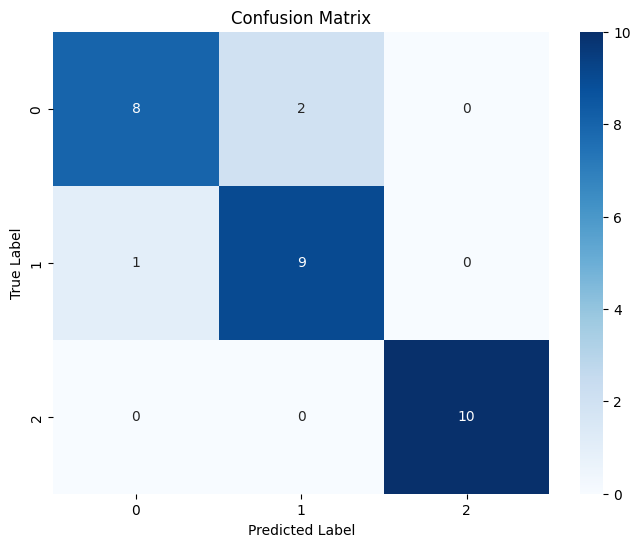

In [ ]:
import seaborn as sns

confusion_mat = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

1/1 [==============================] - 0s 59ms/step


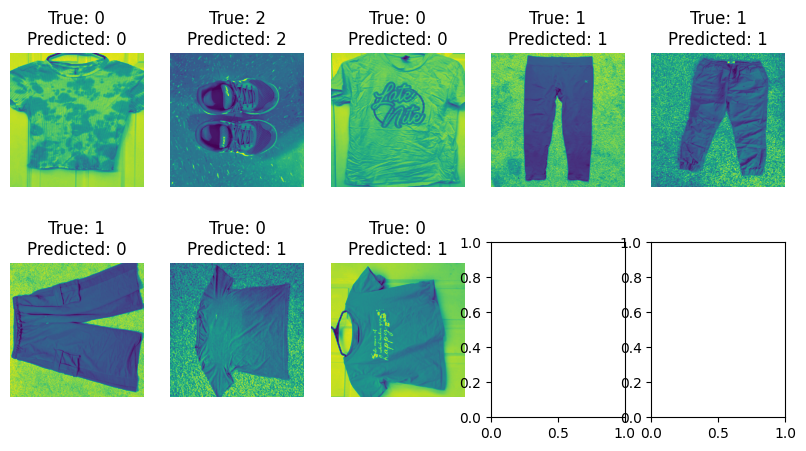

In [ ]:
correct_indices = np.where(predicted_labels == np.argmax(y_test, axis=1))[0]
incorrect_indices = np.where(predicted_labels != np.argmax(y_test, axis=1))[0]

# Display a few examples of correct classifications
plt.figure(figsize=(10, 5))
for i in range(5):  # Display 5 correct examples
    plt.subplot(2, 5, i + 1)
    plt.imshow(X_test[correct_indices[i]])
    plt.title(f'True: {np.argmax(y_test[correct_indices[i]])}\nPredicted: {predicted_labels[correct_indices[i]]}')
    plt.axis('off')

# Display a few examples of incorrect classifications
for i in range(5):  # Display 5 incorrect examples
    plt.subplot(2, 5, i + 6)
    try:
      plt.imshow(X_test[incorrect_indices[i]])
      plt.title(f'True: {np.argmax(y_test[incorrect_indices[i]])}\nPredicted: {predicted_labels[incorrect_indices[i]]}')
      plt.axis('off')
    except:
      pass

plt.show()